In [9]:
import sys
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))

from PIL import Image
import sys
from pathlib import Path
from PIL import Image
import torch
import numpy as np
from molmo_utils import load_model, do_inference, get_coordinates, calculate_probability_of_coordinates
from utils import extract_all, plot_scatter, calculate_normalized_euclidian_distance

In [2]:
model_name = 'allenai/Molmo-7B-D-0924'
model, processor = load_model(model_name)

Loading checkpoint shards:   0%|          | 0/7 [00:00<?, ?it/s]

In [19]:
def calculate_spread(coordinates, width, height):
    max_dist = 0
    for i in range(len(coordinates)):
        for j in range(i + 1, len(coordinates)):
            dist = calculate_normalized_euclidian_distance(coordinates[i][0], coordinates[j][0], width, height)
            if (dist > 1):
                print(f"{coordinates[i]}, {coordinates[j]}, {dist}")
            max_dist = max(max_dist, dist)
    
    return max_dist

In [4]:
def run_experiment(path_to_experiments, prompt_starts, prompt_ends, runs_per_task, temperature):
    tasks, images, ground_truths, _ = extract_all(path_to_experiments)
    softmax_fn = torch.nn.Softmax(dim=-1)
    labels = []

    distances = []
    spreads = []

    distances_what = []
    distances_where = []

    spreads_what = []
    spreads_where = []
    
    for i in range(len(tasks)):
        task = tasks[i]
        labels.append(task)
        ground_truth = ground_truths[i]
        prompt_what = prompt_starts[0] + task + prompt_ends[0]
        prompt_where = prompt_starts[1] + task + prompt_ends[1]
        print(f"Task: {task}")
    
        norm_dist_what = []
        norm_dist_where = []

        coord_what = []
        coord_where = []

        coordinates_of_task = []
        
        with Image.open(images[i]) as image:
            image_width = image.width
            image_height = image.height
    
            prompts = [prompt_what]
            if (len(ground_truth) == 2):
                prompts.append(prompt_where)
                labels.append(task)
    
            for k in range(len(prompts)):
                for j in range(runs_per_task):
                    output_text, output, inputs = do_inference(image, prompts[k], model, processor, temperature)
                    
                    coordinates = get_coordinates(output_text, image_width, image_height)
                    if len(coordinates) == 1:
                        norm_dist = calculate_normalized_euclidian_distance(coordinates[0], ground_truth[k], image_width, image_height)

                        if (k == 0):
                            norm_dist_what.append(norm_dist)
                            coord_what.append(coordinates)
                        else:
                            norm_dist_where.append(norm_dist)
                            coord_where.append(coordinates)

    
            # Per task output
            #all_distances = norm_dist_what + norm_dist_where
            #mean = np.min(all_distances)
            #distances.append(mean)

            #all_coordintaes = coord_what + coord_where
            #max_dist = calculate_spread(all_coordintaes, image_width, image_height)
            #spreads.append(max_dist)
            
    
            mean_what = np.min(norm_dist_what)
            distances_what.append(mean_what)
            max_dist_what = calculate_spread(coord_what, image_width, image_height)
            spreads_what.append(max_dist_what)
            
            distances.append(mean_what)
            spreads.append(max_dist_what)
            
            if (len(norm_dist_where) != 0):
                mean_where = np.min(norm_dist_where)
                distances_where.append(mean_where)
                max_dist_where = calculate_spread(coord_where, image_width, image_height)
                spreads_where.append(max_dist_where)

                distances.append(mean_where)
                spreads.append(max_dist_where)
        
    
  

    plot_scatter(labels, spreads, distances, "Scatterplot for every task", "Minimum distance from ground truth", "Spread of points")
    plot_scatter(["Object to move", "Where to place"], [spreads_what, spreads_where], [distances_what, distances_where], "Scatterplot for difference between object and where to place",  "Minimum distance from ground truth", "Spread of points")

Task: pull the oven tray
Task: move the fruit from the left stove to the sink
Task: open low fridge
Task: open the drawer
Task: Move the can from the top left of the burner to the bottom left of the burner
Task: Place the pot to the right of the blue fork.
Task: move the pot from the right to the left stove
[(174, 185)], [(2, 0)], 1.0104177353946238
[(2, 0)], [(173, 187)], 1.0135876873758876
Task: put potato in pot or pan
Task: take cucumber out of cup
Task: move the banana from the left stove to the sink
Task: pick up the toast and put it to the sink
Task: close the microwave
Task: push the toaster lever
Task: pick up glass cup
Task: take the broccoli and put it between the two right burners
Task: move the pot from the left to the right stove


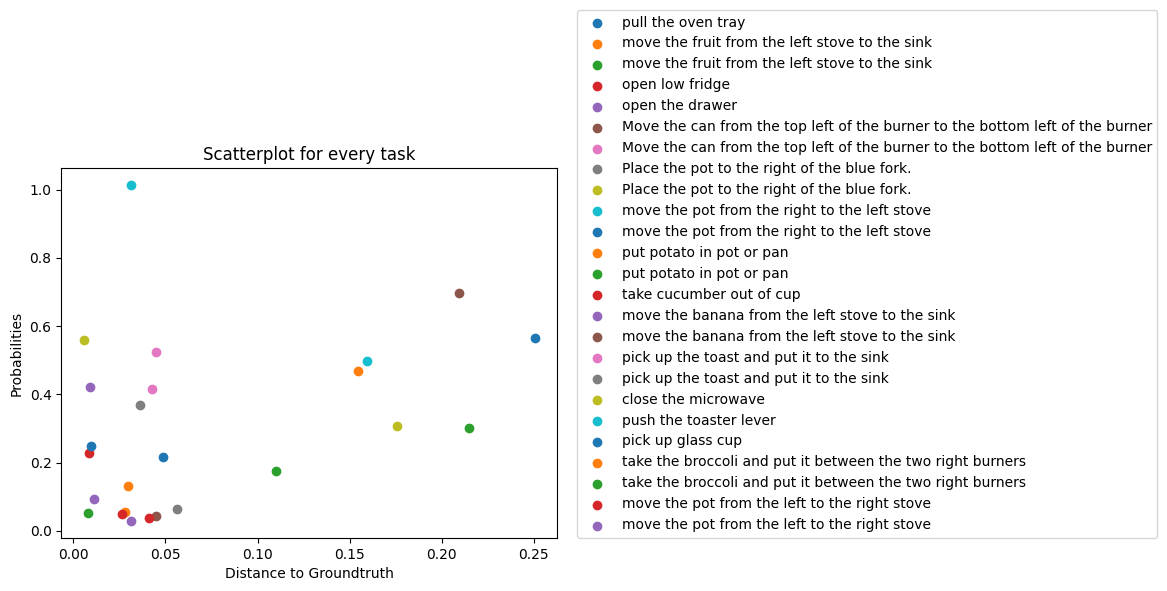

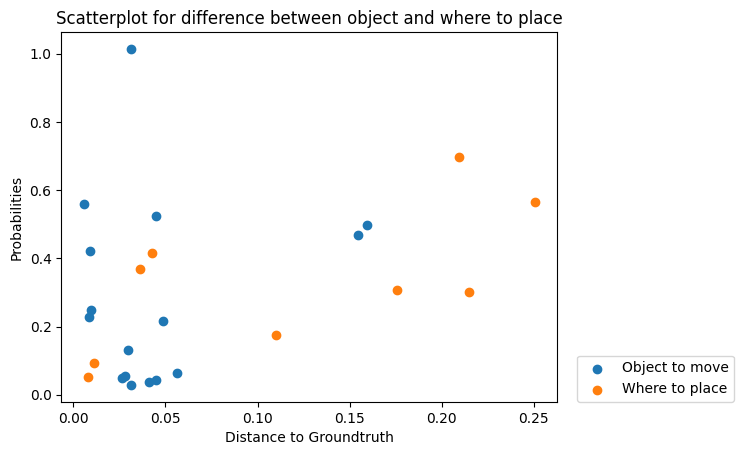

In [45]:
experiment_path = "../data/base_experiments"
num_runs = 5
temperature = 0.6

prompt_starts = ["You are the robot in the picture. Your mission it to guide and support the user in its task to: ", "You are the robot in the picture. Your mission it to guide and support the user in its task to: "]
prompt_ends = [" For that you have to point to the relevant object in the picture. Your output format should be like this: (x1, y1) with (x1, y1) beeing the coordinates of the object to move. Dont output anything else.", " For that you have to point to the place in the picture where the object has to be moved to. Your output format should be like this: (x1, y1) with (x1, y1) beeing the coordinates of the place where the object has to be moved to. Dont output anything else."]

run_experiment(experiment_path, prompt_starts, prompt_ends, num_runs, temperature)

In [5]:
def run_experiment_with_object(path_to_experiments, prompt_starts, prompt_ends, runs_per_task, temperature):
    tasks, images, ground_truths, objects = extract_all(path_to_experiments)
    softmax_fn = torch.nn.Softmax(dim=-1)
    labels = []

    distances = []
    spreads = []

    distances_what = []
    distances_where = []

    spreads_what = []
    spreads_where = []
    
    for i in range(len(tasks)):
        task = tasks[i]
        labels.append(task)
        ground_truth = ground_truths[i]
        objects_of_task = objects[i]
        object = " The releveant object is: " + objects_of_task[0] + " "
        ground_truth = ground_truths[i]
        prompt_what = prompt_starts[0] + task + object + prompt_ends[0]
        prompt_where = prompt_starts[1] + task + object + prompt_ends[1]
        print(f"Task: {task}")
    
        norm_dist_what = []
        norm_dist_where = []

        coord_what = []
        coord_where = []

        coordinates_of_task = []
        
        with Image.open(images[i]) as image:
            image_width = image.width
            image_height = image.height
    
            prompts = [prompt_what]
            if (len(ground_truth) == 2):
                prompts.append(prompt_where)
                labels.append(task)
    
            for k in range(len(prompts)):
                for j in range(runs_per_task):
                    output_text, output, inputs = do_inference(image, prompts[k], model, processor, temperature)
                    
                    coordinates = get_coordinates(output_text, image_width, image_height)
                    if len(coordinates) == 1:
                        norm_dist = calculate_normalized_euclidian_distance(coordinates[0], ground_truth[k], image_width, image_height)

                        if (k == 0):
                            norm_dist_what.append(norm_dist)
                            coord_what.append(coordinates)
                        else:
                            norm_dist_where.append(norm_dist)
                            coord_where.append(coordinates)

    
            # Per task output
            #all_distances = norm_dist_what + norm_dist_where
            #mean = np.min(all_distances)
            #distances.append(mean)

            #all_coordintaes = coord_what + coord_where
            #max_dist = calculate_spread(all_coordintaes, image_width, image_height)
            #spreads.append(max_dist)
            
    
            mean_what = np.min(norm_dist_what)
            distances_what.append(mean_what)
            max_dist_what = calculate_spread(coord_what, image_width, image_height)
            spreads_what.append(max_dist_what)
            
            distances.append(mean_what)
            spreads.append(max_dist_what)
            
            if (len(norm_dist_where) != 0):
                mean_where = np.min(norm_dist_where)
                distances_where.append(mean_where)
                max_dist_where = calculate_spread(coord_where, image_width, image_height)
                spreads_where.append(max_dist_where)

                distances.append(mean_where)
                spreads.append(max_dist_where)
        
    
  

    plot_scatter(labels, spreads, distances, "Scatterplot for every task", "Minimum distance from ground truth", "Spread of points")
    plot_scatter(["Object to move", "Where to place"], [spreads_what, spreads_where], [distances_what, distances_where], "Scatterplot for difference between object and where to place",  "Minimum distance from ground truth", "Spread of points")

Task: pull the oven tray
Task: move the fruit from the left stove to the sink
Task: open low fridge
Task: open the drawer
Task: Move the can from the top left of the burner to the bottom left of the burner
Task: Place the pot to the right of the blue fork.
Task: move the pot from the right to the left stove
Task: put potato in pot or pan
Task: take cucumber out of cup
Task: move the banana from the left stove to the sink
Task: pick up the toast and put it to the sink
Task: close the microwave
Task: push the toaster lever
Task: pick up glass cup
Task: take the broccoli and put it between the two right burners
Task: move the pot from the left to the right stove


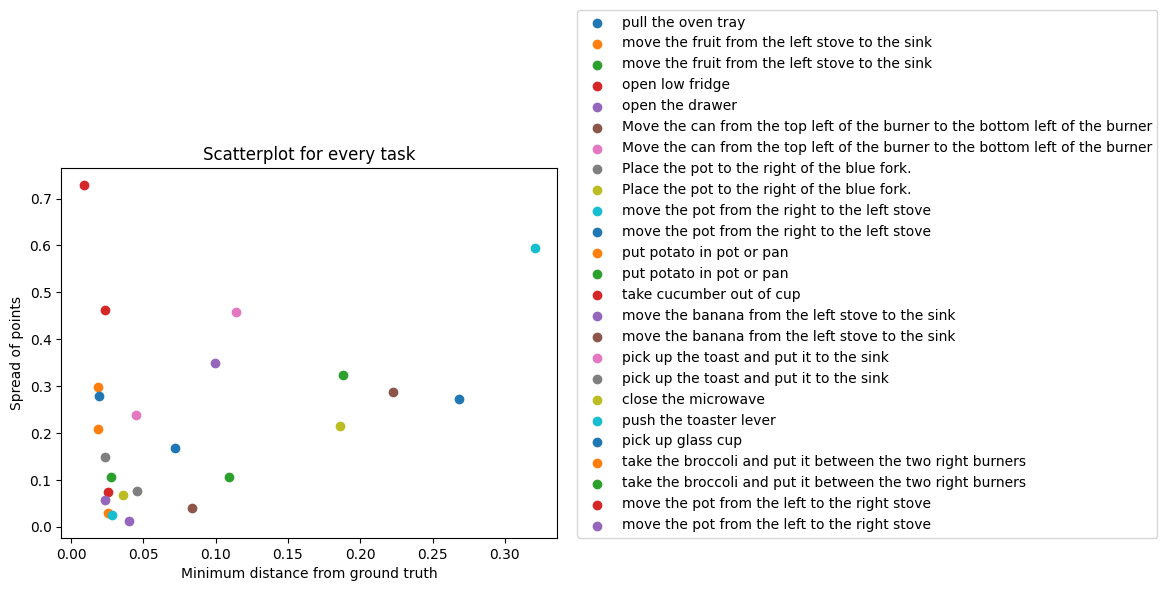

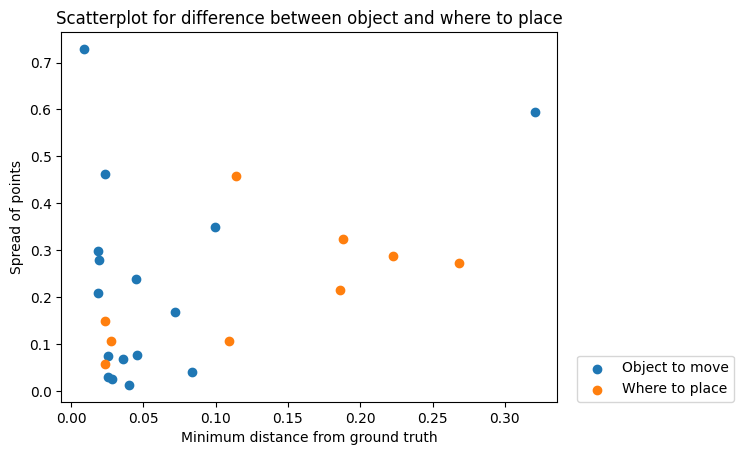

In [20]:
experiment_path = "../data/base_experiments"
num_runs = 5
temperature = 0.6

prompt_starts = ["You are the robot in the picture. Your mission it to guide and support the user in its task to: ", "You are the robot in the picture. Your mission it to guide and support the user in its task to: "]
prompt_ends = [" For that you have to point to the relevant object in the picture. Your output format should be like this: (x1, y1) with (x1, y1) beeing the coordinates of the object to move. Dont output anything else.", " For that you have to point to the place in the picture where the object has to be moved to. Your output format should be like this: (x1, y1) with (x1, y1) beeing the coordinates of the place where the object has to be moved to. Dont output anything else."]

run_experiment_with_object(experiment_path, prompt_starts, prompt_ends, num_runs, temperature)